In [1]:
import json
import pandas as pd
import numpy as np
import json
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from joblib import dump, load
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from mlxtend.plotting import plot_decision_regions

In [2]:
def load_tmdb_movies(path):
    df = pd.read_csv(path, parse_dates=['release_date'])
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

In [3]:
def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

In [4]:
LOST_COLUMNS = [
    'actor_1_facebook_likes',
    'actor_2_facebook_likes',
    'actor_3_facebook_likes',
    'aspect_ratio',
    'cast_total_facebook_likes',
    'color',
    'content_rating',
    'director_facebook_likes',
    'facenumber_in_poster',
    'movie_facebook_likes',
    'movie_imdb_link',
    'num_critic_for_reviews',
    'num_user_for_reviews'
]

In [5]:
TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES = {
    'budget': 'budget',
    'genres': 'genres',
    'revenue': 'gross',
    'title': 'movie_title',
    'runtime': 'duration',
    'original_language': 'language',  # it's possible that spoken_languages would be a better match
    'keywords': 'plot_keywords',
    'vote_count': 'num_voted_users',
                                         }

IMDB_COLUMNS_TO_REMAP = {'imdb_score': 'vote_average'}

In [6]:
def safe_access(container, index_values):
    # return a missing value rather than an error upon indexing/key failure
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan

In [7]:
def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])

In [8]:
def get_companies(company_data):
    companies = [x['name'] for x in company_data if x['name'] == 'Director']
    return safe_access(directors, [0])

In [9]:
def pipe_flatten_names(keywords):
    return '|'.join([x['name'] for x in keywords])

In [10]:
def convert_to_original_format(movies, credits):
    # Converts TMDb data to make it as compatible as possible with kernels built on the original version of the data.
    tmdb_movies = movies.copy()
    tmdb_movies.rename(columns=TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES, inplace=True)
    tmdb_movies['title_year'] = pd.to_datetime(tmdb_movies['release_date']).apply(lambda x: x.year)
    # I'm assuming that the first production country is equivalent, but have not been able to validate this
    tmdb_movies['country'] = tmdb_movies['production_countries'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['company'] = tmdb_movies['production_companies'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['language'] = tmdb_movies['spoken_languages'].apply(lambda x: safe_access(x, [0, 'name']))
    # tmdb_movies['production_companies'] = tmdb_movies['production_companies'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['director_name'] = credits['crew'].apply(get_director)
    tmdb_movies['actor_1_name'] = credits['cast'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['actor_2_name'] = credits['cast'].apply(lambda x: safe_access(x, [1, 'name']))
    tmdb_movies['actor_3_name'] = credits['cast'].apply(lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['genres'] = tmdb_movies['genres'].apply(pipe_flatten_names)
    tmdb_movies['plot_keywords'] = tmdb_movies['plot_keywords'].apply(pipe_flatten_names)
    return tmdb_movies

In [11]:
movies = load_tmdb_movies("Data/Original/tmdb_5000_movies.csv")
credits = load_tmdb_credits("Data/tmdb_5000_credits.csv")
original_format = convert_to_original_format(movies, credits)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 5)
original_format

,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,spoken_languages,status,tagline,movie_title,vote_average,num_voted_users,title_year,country,company,director_name,actor_1_name,actor_2_name,actor_3_name
0,237000000,Action|Adventure|Fantasy|Science Fiction,http://www.avatarmovie.com/,19995,culture clash|future|space war|space colony|so...,English,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2787965087,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,2009.0,United States of America,Ingenious Film Partners,James Cameron,Sam Worthington,Zoe Saldana,Sigourney Weaver
1,300000000,Adventure|Fantasy|Action,http://disney.go.com/disneypictures/pirates/,285,ocean|drug abuse|exotic island|east india trad...,English,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2007-05-19,961000000,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,2007.0,United States of America,Walt Disney Pictures,Gore Verbinski,Johnny Depp,Orlando Bloom,Keira Knightley
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4801,0,,http://shanghaicalling.com/,126186,,English,Shanghai Calling,When ambitious New York attorney Sam is sent t...,0.857008,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-05-03,0,98.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A New Yorker in Shanghai,Shanghai Calling,5.7,7,2012.0,United States of America,NaN,Daniel Hsia,Daniel Henney,Eliza Coupe,Bill Paxton
4802,0,Documentary,NaN,25975,obsession|camcorder|crush|dream girl,English,My Date with Drew,Ever since the second grade when he first saw ...,1.929883,"[{'name': 'rusty bear entertainment', 'id': 87...","[{'iso_3166_1': 'US', 'name': 'United States o...",2005-08-05,0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,My Date with Drew,6.3,16,2005.0,United States of America,rusty bear entertainment,Brian Herzlinger,Drew Barrymore,Brian Herzlinger,Corey Feldman


In [12]:
df = original_format.copy()
features_to_remove =['id','original_title','overview', 'homepage', 'status' , 'plot_keywords', 'spoken_languages', 'gross', 'title_year', 'production_countries','production_companies','tagline', 'vote_average','num_voted_users', 'genres'
]
# df['Success'] = np.where(df['gross'] >= df['gross'].mean(), 1,0)
# target = df['Success']
df.drop(features_to_remove, axis = 1, inplace= True)
df.columns

Index(['budget', 'language', 'popularity', 'release_date', 'duration',
       'movie_title', 'country', 'company', 'director_name', 'actor_1_name',
       'actor_2_name', 'actor_3_name'],
      dtype='object')

In [13]:
# df = original_format.copy()
# features_to_remove =['id','original_title','overview', 'movie_title', 'homepage', 'status' , 'plot_keywords', 'spoken_languages', 'popularity', 'title_year', 'production_countries','production_companies','tagline', 'vote_average','num_voted_users', 'genres', 'Success']
# df['Success'] = np.where(df['popularity'] >= df['popularity'].mean(), 1,0)
# target = df['Success']
# df.drop(features_to_remove, axis = 1, inplace= True)
# df.columns

In [14]:
replace_with_zero = ['duration','budget']

missing_val_cols = list(df.columns[df.isna().any()])
for col in missing_val_cols:
  if col not in replace_with_zero:
    miss_percentage = ((df[col].isna().sum())/4803) * 100 
    print(f'{col} : {str(miss_percentage)}')
    df[col].fillna('Missing', inplace=True)
  else:
    miss_percentage = ((df[col].isna().sum())/4803) * 100 
    print(f'{col} : {str(miss_percentage)}')
     

df.isna().any()

language : 1.7905475744326462
release_date : 0.020820320632937747
duration : 0.041640641265875494
country : 3.622735790131168
company : 7.30793254216115
director_name : 0.6246096189881324
actor_1_name : 0.8952737872163231
actor_2_name : 1.1034769935457007
actor_3_name : 1.311680199875078


budget          False
language        False
                ...  
actor_2_name    False
actor_3_name    False
Length: 12, dtype: bool

In [15]:
df['duration'].fillna(0, inplace=True)

In [16]:
cols = df.columns
for col in cols:
    print(col," ",df[col].isna().sum())

budget   0
language   0
popularity   0
release_date   0
duration   0
movie_title   0
country   0
company   0
director_name   0
actor_1_name   0
actor_2_name   0
actor_3_name   0


In [17]:
df['release_date'] = pd.to_datetime(df['release_date'].astype(str),errors='coerce')
df['dayofrelease']=df['release_date'].dt.strftime('%A')
df.drop(columns=['release_date'], inplace = True)
df.head(3)

,budget,language,popularity,duration,movie_title,country,company,director_name,actor_1_name,actor_2_name,actor_3_name,dayofrelease
0,237000000,English,150.437577,162.0,Avatar,United States of America,Ingenious Film Partners,James Cameron,Sam Worthington,Zoe Saldana,Sigourney Weaver,Thursday
1,300000000,English,139.082615,169.0,Pirates of the Caribbean: At World's End,United States of America,Walt Disney Pictures,Gore Verbinski,Johnny Depp,Orlando Bloom,Keira Knightley,Saturday
2,245000000,Français,107.376788,148.0,Spectre,United Kingdom,Columbia Pictures,Sam Mendes,Daniel Craig,Christoph Waltz,Léa Seydoux,Monday


In [18]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''


features = ['actor_1_name','actor_2_name','actor_3_name','director_name','country', 'company', 'dayofrelease', 'language']
for feature in features:
    df[feature] = df[feature].apply(clean_data)

df

,budget,language,popularity,duration,movie_title,country,company,director_name,actor_1_name,actor_2_name,actor_3_name,dayofrelease
0,237000000,english,150.437577,162.0,Avatar,unitedstatesofamerica,ingeniousfilmpartners,jamescameron,samworthington,zoesaldana,sigourneyweaver,thursday
1,300000000,english,139.082615,169.0,Pirates of the Caribbean: At World's End,unitedstatesofamerica,waltdisneypictures,goreverbinski,johnnydepp,orlandobloom,keiraknightley,saturday
...,...,...,...,...,...,...,...,...,...,...,...,...
4801,0,english,0.857008,98.0,Shanghai Calling,unitedstatesofamerica,missing,danielhsia,danielhenney,elizacoupe,billpaxton,thursday
4802,0,english,1.929883,90.0,My Date with Drew,unitedstatesofamerica,rustybearentertainment,brianherzlinger,drewbarrymore,brianherzlinger,coreyfeldman,friday


In [19]:
target.value_counts()

NameError: name 'target' is not defined

In [259]:
# df['Success'] = np.where(df['gross'] >= df['gross'].mean(), 1,0)
# df.drop(['gross'], axis =1, inplace=True)
df

,budget,language,popularity,duration,movie_title,country,company,director_name,actor_1_name,actor_2_name,actor_3_name,dayofrelease
0,237000000,english,150.437577,162.0,Avatar,unitedstatesofamerica,ingeniousfilmpartners,jamescameron,samworthington,zoesaldana,sigourneyweaver,thursday
1,300000000,english,139.082615,169.0,Pirates of the Caribbean: At World's End,unitedstatesofamerica,waltdisneypictures,goreverbinski,johnnydepp,orlandobloom,keiraknightley,saturday
...,...,...,...,...,...,...,...,...,...,...,...,...
4801,0,english,0.857008,98.0,Shanghai Calling,unitedstatesofamerica,missing,danielhsia,danielhenney,elizacoupe,billpaxton,thursday
4802,0,english,1.929883,90.0,My Date with Drew,unitedstatesofamerica,rustybearentertainment,brianherzlinger,drewbarrymore,brianherzlinger,coreyfeldman,friday


In [404]:
X = df.copy()
y = X.pop('popularity')
X

,budget,language,duration,movie_title,country,company,director_name,actor_1_name,actor_2_name,actor_3_name,dayofrelease
0,237000000,english,162.0,Avatar,unitedstatesofamerica,ingeniousfilmpartners,jamescameron,samworthington,zoesaldana,sigourneyweaver,thursday
1,300000000,english,169.0,Pirates of the Caribbean: At World's End,unitedstatesofamerica,waltdisneypictures,goreverbinski,johnnydepp,orlandobloom,keiraknightley,saturday
...,...,...,...,...,...,...,...,...,...,...,...
4801,0,english,98.0,Shanghai Calling,unitedstatesofamerica,missing,danielhsia,danielhenney,elizacoupe,billpaxton,thursday
4802,0,english,90.0,My Date with Drew,unitedstatesofamerica,rustybearentertainment,brianherzlinger,drewbarrymore,brianherzlinger,coreyfeldman,friday


In [405]:
from sklearn.model_selection import GroupShuffleSplit

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30)
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, X['movie_title'])

In [406]:
X_train.head(5)

,budget,language,duration,movie_title,country,company,director_name,actor_1_name,actor_2_name,actor_3_name,dayofrelease
1,300000000,english,169.0,Pirates of the Caribbean: At World's End,unitedstatesofamerica,waltdisneypictures,goreverbinski,johnnydepp,orlandobloom,keiraknightley,saturday
2,245000000,français,148.0,Spectre,unitedkingdom,columbiapictures,sammendes,danielcraig,christophwaltz,léaseydoux,monday
3,250000000,english,165.0,The Dark Knight Rises,unitedstatesofamerica,legendarypictures,christophernolan,christianbale,michaelcaine,garyoldman,monday
4,260000000,english,132.0,John Carter,unitedstatesofamerica,waltdisneypictures,andrewstanton,taylorkitsch,lynncollins,samanthamorton,wednesday
5,258000000,english,139.0,Spider-Man 3,unitedstatesofamerica,columbiapictures,samraimi,tobeymaguire,kirstendunst,jamesfranco,tuesday


In [407]:
X_train.pop('movie_title')
X_valid.pop('movie_title')

0                                       Avatar
8       Harry Potter and the Half-Blood Prince
                         ...                  
4800                 Signed, Sealed, Delivered
4801                          Shanghai Calling
Name: movie_title, Length: 1201, dtype: object

In [408]:
print("X_train: ", X_train.shape, " ","X_valid: ", X_valid.shape)

X_train:  (3602, 10)   X_valid:  (1201, 10)


In [409]:
features_cat = ['country','company','director_name','actor_1_name','actor_2_name','actor_3_name','dayofrelease']
features_num = ['budget', 'duration']

In [410]:
from sklearn.compose import make_column_transformer, make_column_selector

preprocessor = make_column_transformer(
    (StandardScaler(),
     make_column_selector(dtype_include=np.number)),
    # (OneHotEncoder(sparse=False,handle_unknown = 'ignore'),
    #  make_column_selector(dtype_include=object)),
)

enc = OneHotEncoder(handle_unknown = 'ignore')
enc.fit(X_train)

X_train = enc.transform(X_train).toarray()
X_valid = enc.transform(X_valid).toarray()

In [414]:
X_valid.shape

(1201, 10098)

In [415]:
X_train = preprocessor.fit_transform(X_train)
y_train = np.log(y_train) # log transform target instead of standardizing
X_train

ValueError: make_column_selector can only be applied to pandas dataframes

In [376]:
X_valid = preprocessor.fit_transform(X_valid)
y_valid = np.log(y_valid) # log transform target instead of standardizing
X_valid

array([[ 5.15626637,  1.91758306],
       [ 5.5156781 ,  1.161783  ],
       [ 5.99489375,  1.58692053],
       ...,
       [-0.70885389, -1.24732969],
       [-0.71390962, -1.05837967],
       [-0.71412527, -0.82219215]])

In [377]:
print("X_train: ", X_train.shape, " ","X_valid: ", X_valid.shape)

X_train:  (3602, 2)   X_valid:  (1201, 2)


In [378]:
input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [2]


In [379]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model = keras.Sequential([
    layers.Dense(512,activation='relu', input_shape=input_shape),
    layers.Dense(512, activation = 'relu'),
    layers.Dense(512, activation = 'relu'),
    layers.Dense(1),
])

In [380]:
model.compile(
    optimizer='adam',
    loss='mae'
)

In [381]:
history = model.fit(
    X_train,y_train,
    validation_data=(X_valid, y_valid),
    batch_size= 256,
    epochs = 100,
    callbacks=[early_stopping], # put your callbacks in a list
    verbose=0,  # turn off training log
)

<AxesSubplot:>

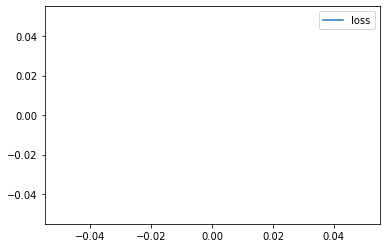

In [382]:
import pandas as pd

history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5. You can change this to get a different view.
history_df.loc[5:, ['loss']].plot()